In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from DDUN.UNET import *
from DDUN.DataPrep import *
model = Diffusion_Unet()
dataloader = Fashion_Mnist_loader(data_path="data", batch_size=16, shuff=True, drop_last=True)

sample = next(iter(dataloader))[0]
sample.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([16, 1, 28, 28])

In [15]:
from DDUN.Forward import *
from DDUN.Loss import get_loss


T = 50
START = 1e-4
END = 1e-2
betas = intiate_betas(T, START, END)
alphas_cumprod = calc_cumprod_alphas(betas)
alphas_cumprod_prev = clac_cumoprod_alphas_prev(betas)

sqrt_recip_alphas = calc_sqrt_recip_alpha(betas)
sqrt_alphas_cumpord = calc_sqrt_cumprod_alphas(betas)
sqrt_one_minus_alphas_cumpord = calc_sqrt_one_minus_cumpord_alphas(betas)

postierior_variance = calc_postierior_variance(betas)

In [16]:
defused_sample = Forward_pass(
    sample,
    torch.randint(0, T, (16,)),
    sqrt_alphas_cumpord,
    sqrt_one_minus_alphas_cumpord,
    device="cpu",
    torch_seed=42,
)

t = torch.randint(0, T, (16,))
prediction = model(sample, t)




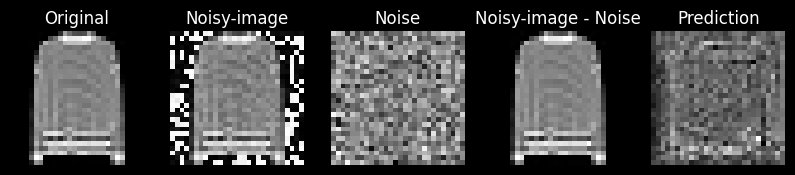

In [36]:
image = sample[0][0]
noisy_img = defused_sample[0][0][0]
noise = defused_sample[1][0][0]
prediction_image = prediction[0][0]

plt.figure(figsize=(10, 10))
plt.subplot(1, 5, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(prep_imshow(image), cmap="gray")

plt.subplot(1, 5, 2)
plt.title('Noisy-image')
plt.axis('off')
plt.imshow(prep_imshow(noisy_img), cmap="gray")

plt.subplot(1, 5, 3)
plt.title('Noise')
plt.axis('off')
plt.imshow(prep_imshow(noise), cmap="gray")

plt.subplot(1, 5, 4)
plt.title('Noisy-image - Noise')
plt.axis('off')
plt.imshow(prep_imshow(noisy_img- noise), cmap="gray")

plt.subplot(1, 5, 5)
plt.title('Prediction')
plt.axis('off')
plt.imshow(prep_imshow(prediction_image.detach()), cmap="gray")


## testing loss

In [38]:
get_loss(
    model, 
    sample,
    torch.randint(0, T, (16,)),
    sqrt_alphas_cumpord,
    sqrt_one_minus_alphas_cumpord,
    device="cpu",
    torch_seed=42,
)

tensor(0.2622, grad_fn=<MeanBackward0>)

#### Model mean :

$$
\mu = \sqrt{\bar{\alpha_t}} *(x - \beta_t \frac{P_{model}(x,t)}{\sqrt{1-\alpha_t}} )
$$


#### Model variance :

- posterior variance at time t

$$
\sigma_{posterior-variance} = \beta * \frac{1 - \alpha_{comprod-previous}}{1- \alpha_{cumprod}}
$$



In [39]:
@torch.no_grad()
def Sample_timestep(x, t):
    # * get beta at time t
    beta_t = get_index_from_list(betas, t, x.shape)

    # * get sqrt of alphas cumpord at time t
    sqrt_one_minus_alphas_cumpord_t = get_index_from_list(
        sqrt_one_minus_alphas_cumpord, t, x.shape
    )

    # * get sqrt of reciprocal alphas at time t
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # * model mean
    model_mean = sqrt_recip_alphas_t * (x - beta_t * model(x, t) / sqrt_one_minus_alphas_cumpord_t)
    
    #* model variance : postierior variance fixed variance at time t
    model_variance = get_index_from_list(postierior_variance, t, x.shape)
    
    if t == 0:
        return model_mean, # model_variance = 0, at t = 0
    
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(model_variance) * noise
    

tensor([39, 34, 24, 29, 15, 39, 42, 33,  2, 41, 41, 16, 20, 45, 11, 28])